# 导入原始数据

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size':20 }) 
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Log等级总开关
formatter = logging.Formatter('%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s')
logfile='Preprocess.log'
outlog=logging.FileHandler(logfile, mode='a')
outlog.setLevel(logging.DEBUG) # 输出到log的等级开关
outlog.setFormatter(formatter)
logger.addHandler(outlog)

screenlog=logging.StreamHandler()
screenlog.setLevel(logging.INFO)
screenlog.setFormatter(formatter)
logger.addHandler(screenlog)

# mce_log数据分析及修改意见

不同vendor的统计特性是否不同？
- 是否需要对结果按vendor加权；
- 对不同vendor分别建模、归一化、集成
- 用vendor构造二值掩码加入网络？

In [2]:
raw_mce = pd.read_csv('memory_sample_mce_log_round1_a_train.csv')

In [4]:
logging.info((raw_mce.groupby('serial_number').agg(dict(vendor='count')) > 10000).sum()) # 记录数大于10k的服务器数量

2021-03-11 13:38:13,950 - <ipython-input-4-91bbeb567b38>[line:1] - INFO: vendor    120
dtype: int64


In [5]:
def drop_dups(data, keys=['serial_number','collect_time', 'mca_id']):
        
        logging.info('删除数据中的重复条目')
        logging.info('主键：{0}'.format(keys))
        logging.info('去重前数据大小：{0}'.format(data.shape))
        if 'collect_time' in data.columns:
            data_out = data.drop_duplicates(subset=keys, keep='first',inplace=False)
        else:
            data_out = data.drop_duplicates(subset=keys, keep='first',inplace=False)
        logging.info('去重后数据大小：{0}'.format(data_out.shape))

        return data_out
    
def pre(df):

    def to_time(df):
        
        print('transform time stamps')
        df.collect_time = pd.to_datetime(df['collect_time'])
        df = df.sort_values(by='collect_time', ascending=True)

        return df

#     def complete(df):

#         # Complete the nulls in column 'vendor via modes within one serial_number

#         ## Solution:

#         df_mode = raw_mce.groupby('serial_number').agg(dict(vendor=pd.Series.mode, manufacturer=pd.Series.mode))
#         vendor_map = {}
#         manufacturer_map = {}

#         for item in df_mode.index:
#             vendor_map[item] = df_mode.vendor[item]
#             manufacturer_map[item] = df_mode.manufacturer[item]

#         raw_mce[raw_mce.vendor.isnull()]
#         raw_mce2[raw_mce2.vendor.isnull()] 
        
#         ## But:

#         # The nulls only happens iff serial_number == 'server_59596'
#         # So we can drop these observations directly.

        df = df.drop(df[df.serial_number == 'server_59596'].index)

#         ## For mca_id, complete them via mode nums
#         # Some cases would have two equal modes, we select one randomly
#         # to fill in the nulls, and the remained errors are regarded as noise.

#         df_mode = raw_mce.groupby('serial_number').agg(dict(mca_id=pd.Series.mode))
#         mca_id_map = {}

#         for item in df_mode.index:
#             mca_id_map[item] = df_mode.mca_id[item]
        
#         for item in df[df.mca_id.isnull()].index:
#             df.mca_id[item] = mca_id_map[df.serial_number[item]]
    
    def correct(df):

        # 主要针对数据标签不一致的问题，但是测试集其实也会面对这个问题，
        # 且我们不好对测试集这类特征denoise。因此不如先把这个noise留下来？

        pass
    df = drop_dups(df)
    df = to_time(df)

    return df

In [ ]:
mid_mce = pre(raw_mce)

In [40]:
raw_mce_test = pd.read_csv('memory_sample_mce_log_round1_a_test.csv')
raw_mce_test[raw_mce_test.serial_number == 'server_22958']

,serial_number,mca_id,transaction,collect_time,manufacturer,vendor
27692,server_22958,CC,1.0,2019-06-04 05:57:21,0,1.0
27693,server_22958,CC,1.0,2019-06-04 05:57:21,0,1.0
27694,server_22958,CC,1.0,2019-06-04 05:57:21,0,1.0
27695,server_22958,CC,1.0,2019-06-04 05:57:21,0,1.0
27696,server_22958,CC,1.0,2019-06-04 05:57:21,0,1.0
...,...,...,...,...,...,...
28286,server_22958,NaN,1.0,2019-06-04 06:30:07,0,1.0
28287,server_22958,NaN,1.0,2019-06-04 06:30:13,0,1.0
28288,server_22958,CC,NaN,2019-06-04 06:22:39,0,1.0
28289,server_22958,CC,NaN,2019-06-04 06:28:14,0,1.0


In [66]:
logging.info(raw_mce.mca_id.unique()) # 总共有18种内存排列位置
logging.info(raw_mce.vendor.unique()) # 总共有3个内存厂商
logging.info(raw_mce.manufacturer.unique()) # 总共有3个服务器厂商
logging.info(raw_mce.serial_number.unique().shape) # 总共有几个server

['Z' nan 'AP' 'AF' 'E' 'CD' 'BB' 'C' 'CC' 'F' 'G' 'EE' 'AA' 'AE' 'BC' 'AZ'
 'DE' 'FF']
[ 1.  0.  2. nan]
[0 1 3 2]
(17538,)


In [27]:
print(raw_mce[raw_mce.transaction.isnull()].groupby('serial_number').vendor.count().sum()) # mca_id is null
print(raw_mce[raw_mce.mca_id.isnull()].groupby('serial_number').vendor.count().sum()) # mca_id is null

423236
299598


In [29]:
mid_mce.groupby('mca_id').count().vendor # 有18种mca_id(内存分布)，类别分布不均匀，且每个mca_id的transaction的几率不均匀

mca_id
AA         247
AE      103258
AF      223567
AP    16496199
AZ         126
BB      373555
BC         129
C         5678
CC      273560
CD        1448
DE          69
E       318439
EE         113
F       270451
FF         147
G       385642
Z     20884798
Name: vendor, dtype: int64

In [30]:
mid_mce.groupby('serial_number').agg(dict(manufacturer='nunique', vendor='nunique', collect_time='count', transaction='nunique')) 
# 基本所有的server都只有一个manufacture和vendor，因此对不符合的要进行标签平滑
# 剔除collect_time时间过少的服务器
# 所有的服务器对应一段连续的观测时间, 但这些时间之间存在重叠

,manufacturer,vendor,collect_time,transaction
serial_number,,,,
server_1,1,1,20092,3
server_10,1,1,38,1
server_100,1,1,153,2
server_1000,1,1,1,1
server_10000,1,1,1,1
...,...,...,...,...
server_9975,1,1,1,0
server_9984,1,1,6,2
server_9989,1,1,42,2


In [31]:
mid_mce[mid_mce.serial_number == 'server_55401'].sort_values('collect_time') 
# 出现了重复现象，数据需要去重;
# 出现了采样频率不一致的情况，聚合均值向量时，考虑插值、加权求和

,serial_number,mca_id,transaction,collect_time,manufacturer,vendor
53877521,server_55401,CC,1.0,2019-01-01 06:14:54,2,0.0
53877522,server_55401,CC,1.0,2019-01-02 06:09:36,2,0.0
53877523,server_55401,CC,1.0,2019-01-03 06:04:18,2,0.0
53877524,server_55401,CC,1.0,2019-01-05 05:53:43,2,0.0
53877525,server_55401,CC,1.0,2019-01-06 05:48:26,2,0.0
...,...,...,...,...,...,...
53877667,server_55401,CC,1.0,2019-05-27 17:16:52,2,0.0
53877668,server_55401,CC,1.0,2019-05-28 17:11:34,2,0.0
53877669,server_55401,CC,1.0,2019-05-29 17:06:16,2,0.0
53877670,server_55401,CC,1.0,2019-05-30 17:00:59,2,0.0


array([ 0., nan,  1.,  2.,  3.])

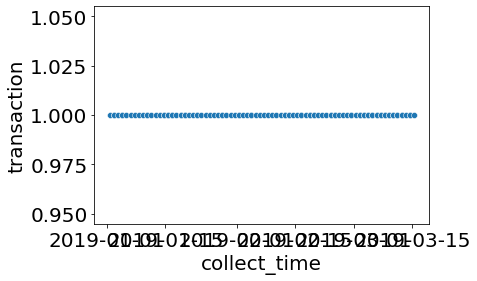

In [34]:
# ax1 = sns.scatterplot(x='collect_time', y='transaction', data = mid_mce[mid_mce.serial_number == 'server_55401'])
# ax2 = sns.scatterplot(x='collect_time', y='transaction', data = mid_mce[mid_mce.serial_number == 'server_55402'])
ax3 = sns.scatterplot(x='collect_time', y='transaction', data = mid_mce[mid_mce.serial_number == 'server_55405'])
mid_mce.transaction.unique()
# 针对transaction，总共有0，1，2，3以及NAN四种取值。考虑到其曲线非常平稳，因此可以直接取前后最小值
# 大部分时间序列都是连续的，但是有少部分尺度不一且不连续，需要对其进行给定尺度下的单独评价和考量

In [35]:
# TODO 尺度聚合、评价算法

def complete(df, column):
    for i in range(df.shape[0]):
        print(df.loc[i,:])
        if df.loc[i, column] == np.nan:
            print(i)
        break

complete(mid_mce, 'transaction')

serial_number           server_31576
mca_id                             Z
transaction                      0.0
collect_time     2019-01-14 18:17:47
manufacturer                       0
vendor                           1.0
Name: 0, dtype: object


AxesSubplot(0.125,0.125;0.775x0.755)


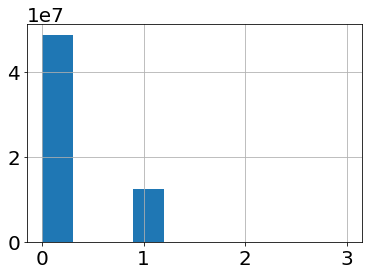

In [37]:
print(raw_mce.transaction.hist())

# Kernel数据分析

In [3]:
raw_kernel = pd.read_csv('memory_sample_kernel_log_round1_a_train.csv')

In [169]:
# 首先对各特征非NULL值数量进行计算
logging.info(raw_kernel.shape[0] - raw_kernel.isna().sum().sort_values(ascending=False))# 非空特征数量
# 直接舍弃全为null的特征，并设置阈值保留不为null的特征

2021-03-06 13:20:18,221 - <ipython-input-169-4ac8b0eb06f2>[line:2] - INFO: 2_sel                   0
3_hwerr_n               0
2_hwerr_s               0
3_hwerr_m               0
_hwerr_cd               0
3_hwerr_r               0
1_hwerr_fl              0
3_hwerr_kp            326
3_cmci_sub            895
1_hwerr_f            1024
3_cmci_det           1634
3_hwerr_o            3961
3_hwerr_pi           3962
2_hwerr_p            3962
2_hwerr_c            4720
3_hwerr_p            6272
2_hwerr_ce           9239
3_hwerr_as          12287
1_hwerr_st          15230
3_hwerr_mce_l       17911
1_hwerr_e           26631
1_ke                38199
1_hw_mem_c         706587
3_sup_mce_note     827632
vendor            3511861
serial_number     3511864
manufacturer      3511864
collect_time      3511864
dtype: int64


In [164]:
def process_kernel(df=raw_kernel, save_num=4):
    
    def drop_cols(df, save_num): # 保留NULL值最多的日志（时间戳、vendor等没有缺失值的特征不在这个10里边）
    
        non_null = (df.shape[0] - df.isna().sum()).sort_values()
        save_columns = non_null.index[-4-save_num:]
        logging.info('we select the feature set in kernel:{0}'.format(save_columns))
        
        return df[save_columns]

    df = drop_dups(df)
    df = drop_cols(df, save_num)
    
    return df

In [ ]:
process_kernel()

# Address数据分析

In [4]:
raw_add = pd.read_csv('memory_sample_address_log_round1_a_train.csv')

In [6]:
print(raw_add.serial_number.unique().shape)

(17401,)


The number of unique values in row: (131073,)
The number of unique values in col: (231,)
The number of maximum values in row: 131071
The number of maximum values in col: 1016


Text(0, 0.5, 'log2(num)')

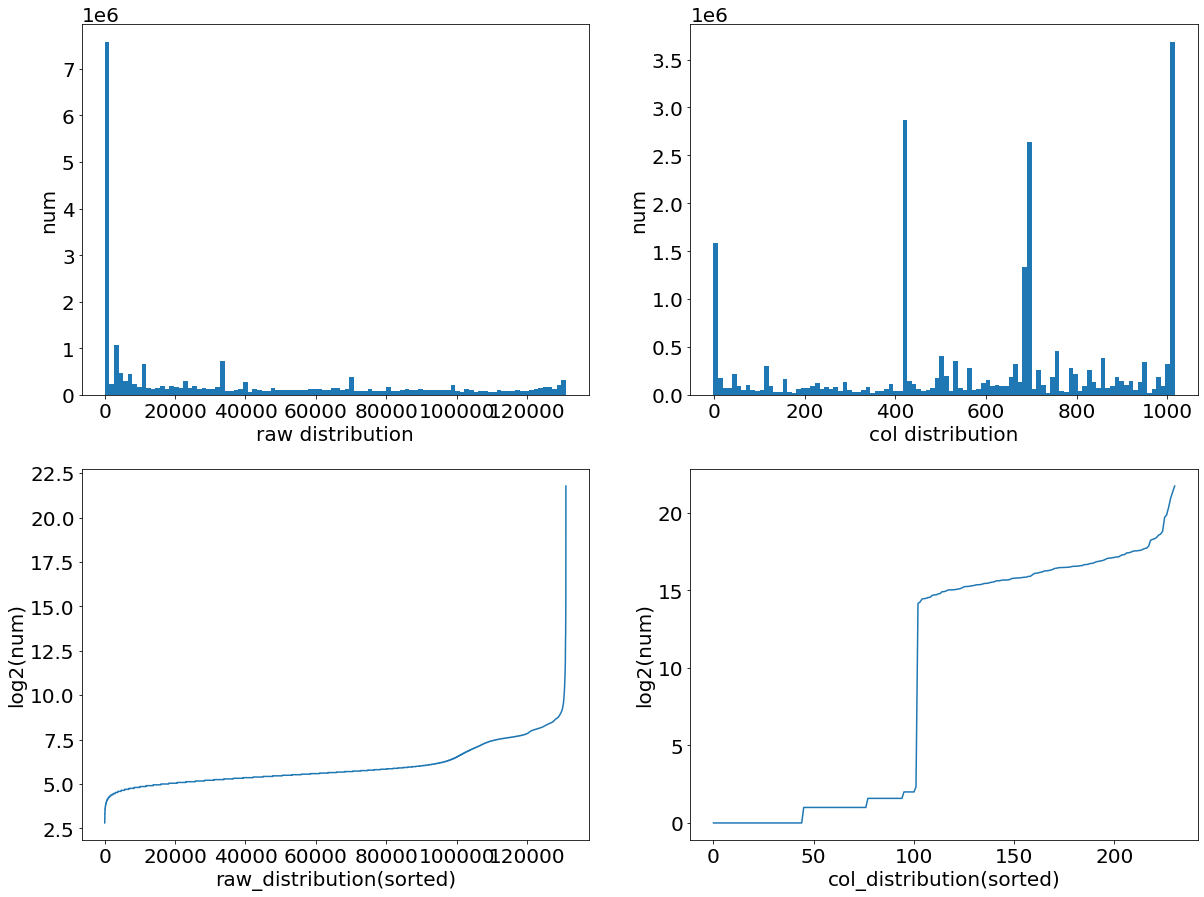

In [53]:
# 绘制row-col的1维边缘分布
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.hist(x=raw_add.row, bins=100)
plt.xlabel('raw distribution'); plt.ylabel('num')
plt.subplot(2, 2, 2)
plt.hist(x=raw_add.col, bins=100)
plt.xlabel('col distribution'); plt.ylabel('num')

plt.subplot(2, 2, 3)
plt.plot(np.log2(raw_add.groupby('row').agg(dict(collect_time='count')).collect_time.sort_values().values))
plt.xlabel('raw_distribution(sorted)'); plt.ylabel('log2(num)')

plt.subplot(2, 2, 4)
plt.plot(np.log2(raw_add.groupby('col').agg(dict(collect_time='count')).collect_time.sort_values().values))
plt.xlabel('col_distribution(sorted)'); plt.ylabel('log2(num)')

print('The number of unique values in row: {0}'.format(raw_add.row.unique().shape))
print('The number of unique values in col: {0}'.format(raw_add.col.unique().shape))
print('The number of maximum values in row: {0}'.format(raw_add.row.max()))
print('The number of maximum values in col: {0}'.format(raw_add.col.max()))
print('Thus the obvious sparsity of col data is witnessed, while the distribution for raw data has more coverage of value zones, but according to the figures below, it can be sparse under some thresholds.')

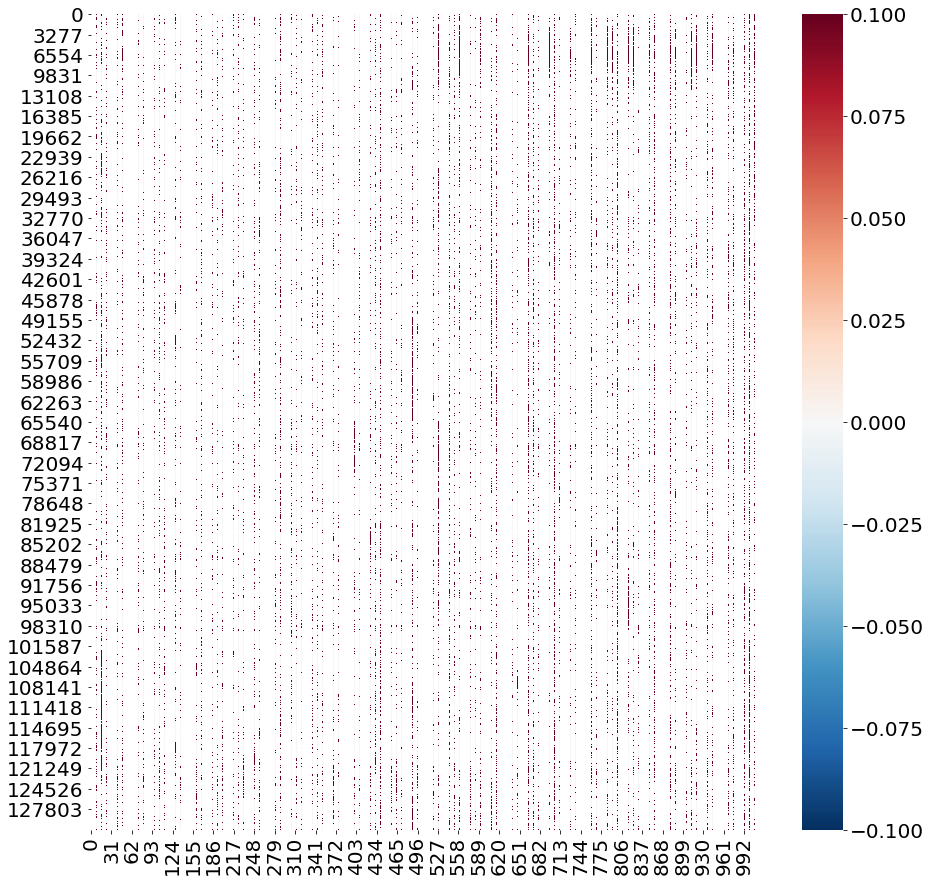

In [52]:
# 绘制row-col的联合分布
temp = raw_add.groupby(['row','col']).agg(dict(vendor='count'))
temp2 = pd.DataFrame(np.zeros((raw_add.row.max()+1, raw_add.col.max()+1)))

def distribution_2d(idx):
    global temp
    global temp2
    temp2.iloc[idx[0], idx[1]] = temp.loc[idx].values
    
map(distribution_2d, temp.index)

plt.figure(figsize=(15,15))
sns.heatmap(np.log10(temp2), cmap= "RdBu_r")
plt.show()

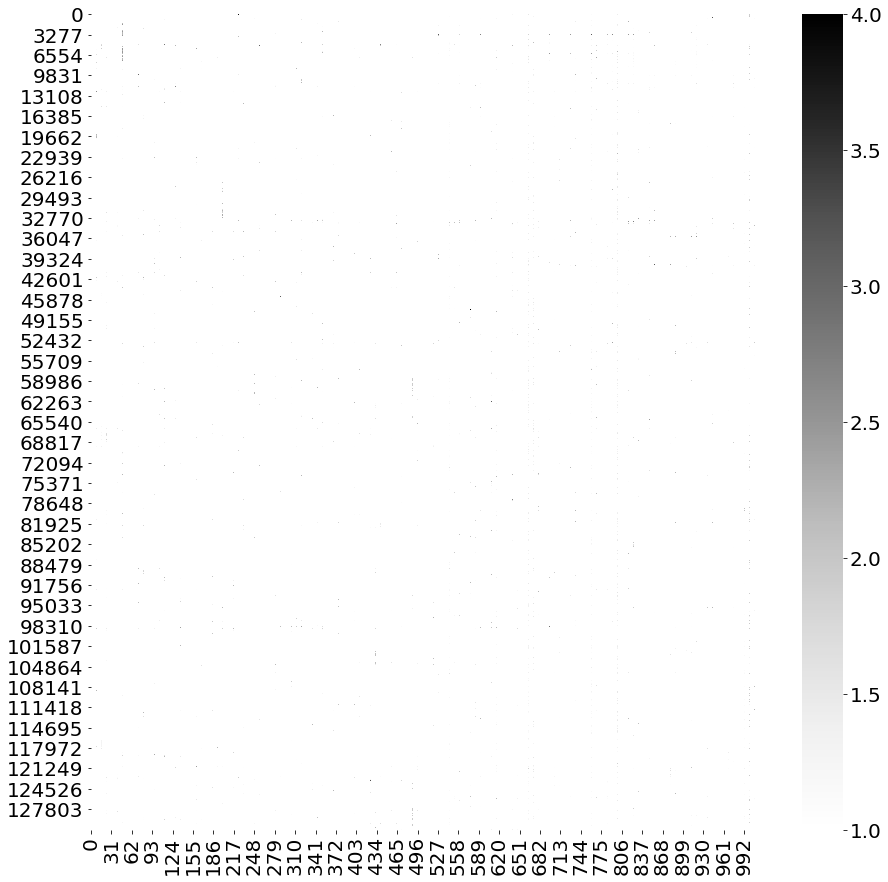

In [68]:
plt.figure(figsize=(15,15))
sns.heatmap(np.log10(temp2), cmap= "Greys", vmin=1, vmax=4) # 区间在[10,10000]
plt.show()

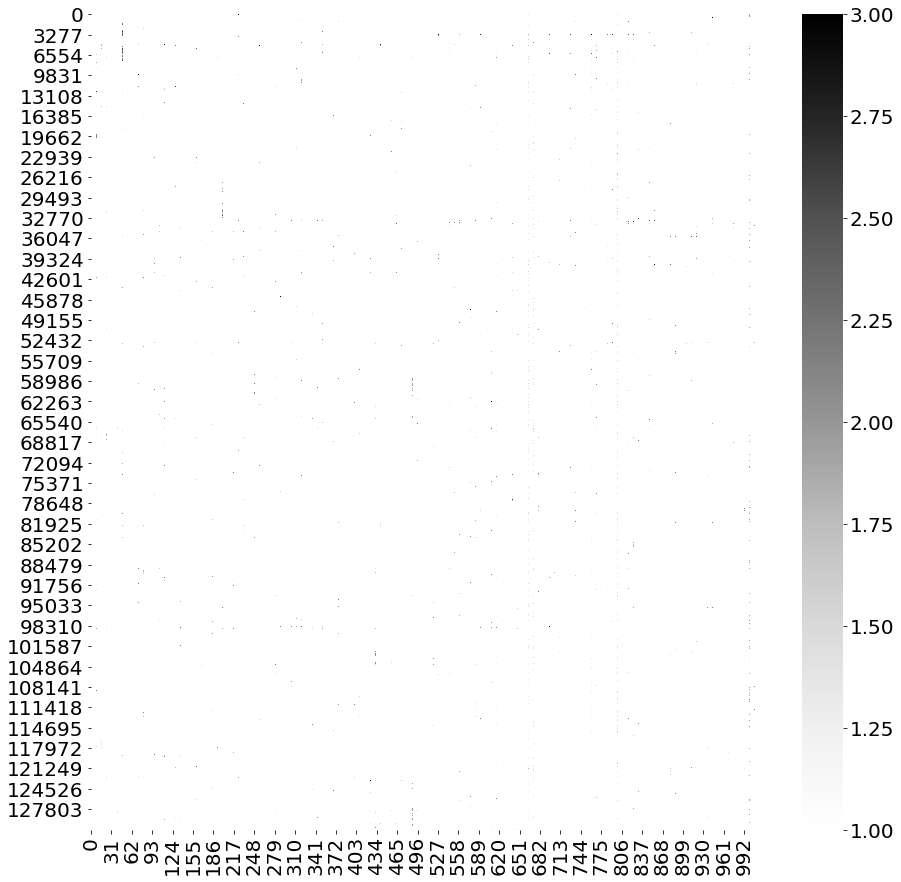

In [69]:
plt.figure(figsize=(15,15))
sns.heatmap(np.log10(temp2), cmap= "Greys", vmin=1, vmax=3) # 区间在[10,1000]
plt.show()

In [8]:
def process_address(df=raw_kernel, save_num_col=4, save_num_row=4):
    
    def drop_cols(data, save_num_row): # 保留NULL值最多的日志（时间戳、vendor等没有缺失值的特征不在这个10里边）
        
        data_out = data
        # 对col做聚合，并按照日志上报的次数从大到小排序 
        df_col = data.groupby(['col']).agg(dict(collect_time='count')).collect_time.sort_values(ascending=False)
        logging.debug('数据按列聚合并将次数倒序排列：{0}'.format(df_col))

        # 选择日志上报最多的前save_num_row个row
        save_cols = df_col.index[:save_num_col]
        logging.info('选择保留的列及其出现频率:{0}'.format(df_col[save_cols]))
        
        # 对不在保留col集合里的，将其统一置为-2
        def row_map(x, save_cols=save_cols):

            if x in save_cols:     
                return x
            else:   
                return -2
            return x

        data_out.loc[:,'col'] = data['col'].map(row_map)
        logging.info('有效列占总数的{0}'.format(df_col[save_cols].values.sum()/data.shape[0]))

        return data_out
        
    
    def drop_rows(data, save_num_col): # 保留NULL值最多的日志（时间戳、vendor等没有缺失值的特征不在这个10里边）

        data_out = data
        # 对row做聚合，并按照日志上报的次数从大到小排序 
        df_row = data.groupby(['row']).agg(dict(collect_time='count')).collect_time.sort_values(ascending=False)
        logging.debug('数据按行聚合并将次数倒序排列：{0}'.format(df_row))

        # 选择日志上报最多的前save_num_row个row
        save_rows = df_row.index[:save_num_row]
        logging.info('选择保留的行及其出现频率:{0}'.format(df_row[save_rows]))
        
        # 对不在保留row集合里的，将其统一置为-1
        def row_map(x, save_rows=save_rows):

            if x in save_rows:     
                return x
            else:   
                return -2
            return x

        data_out.loc[:,'row'] = data['row'].map(row_map)
        logging.info('有效行占总数的{0}'.format(df_row[save_rows].values.sum()/data.shape[0]))
        
        return data_out

    df = drop_dups(raw_add, ['collect_time', 'serial_number', 'memory','bankid'])
    df = drop_cols(df, save_num_col)
    df = drop_rows(df, save_num_row)
    return df

In [ ]:
temp = process_address(raw_add, 20, 20).groupby('col').count()

# Failure数据分析

In [5]:
raw_failure = pd.read_csv('memory_sample_failure_tag_round1_a_train.csv')

In [7]:
# Each server has at most 1 bug. #
raw_failure.groupby('serial_number').agg(dict(failure_time='count')).failure_time.unique() 

array([1])

In [8]:
raw_failure.head(5)

,serial_number,failure_time,tag,manufacturer,vendor
0,server_1789,2019-02-04 20:03:04,0,0,0
1,server_13003,2019-03-03 16:11:54,0,0,0
2,server_15764,2019-04-11 08:23:44,0,0,0
3,server_27567,2019-03-30 17:36:08,0,0,0
4,server_33559,2019-03-19 07:01:24,0,0,0


<AxesSubplot:xlabel='Density', ylabel='vendor'>

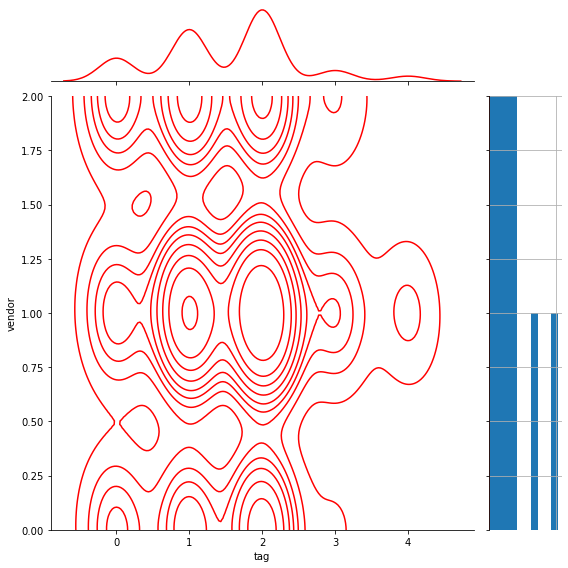

In [82]:
# Distribution of bugs and vendors
ax = sns.jointplot(x='tag', y='vendor', kind='kde', color='r', data=raw_failure, height=8, dropna=True, ylim=[0,2])
raw_failure.groupby(['vendor', 'tag']).count().serial_number.hist()
# 不平衡分类：各错误数量都不超过一个量级；但是错误-厂商耦合后，差别大约有一个量级

# JOIN方法
基本的join方法有inner、out、left三种。其中inner直接删除键值不匹配的item，left方法保留左侧表中的键值不匹配的item，out保留所有键值不匹配的item


对本题，考虑到各表之间不是完备映射，如kernel里的某些collect_time和serial_number在mce里没有。因此**left join会有风险**（kernel里的部分数据会丢失）。针对这一问题，需要进行多种join方法的实验，找出**故障信息**损失最小的join方法。

In [13]:
raw_kernel.column

,collect_time,1_hwerr_f,1_hwerr_e,2_hwerr_c,2_sel,3_hwerr_n,2_hwerr_s,3_hwerr_m,1_hwerr_st,1_hw_mem_c,...,_hwerr_cd,3_sup_mce_note,3_cmci_sub,3_cmci_det,3_hwerr_pi,3_hwerr_o,3_hwerr_mce_l,serial_number,manufacturer,vendor
0,2019-01-14 18:19:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,server_31576,0,1.0
1,2019-01-14 18:20:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,server_31576,0,1.0
2,2019-01-14 18:25:51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,server_31576,0,1.0
3,2019-01-14 18:29:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,server_31576,0,1.0
4,2019-01-14 18:32:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,server_31576,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511859,2019-01-16 22:03:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,server_19459,1,1.0
3511860,2019-01-16 22:03:43,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,server_19459,1,1.0
3511861,2019-01-16 22:05:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,server_19459,1,1.0
3511862,2019-01-16 22:06:51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,server_19459,1,1.0


In [10]:
temp1 = drop_dups(raw_mce, ['serial_number','collect_time', 'mca_id'])
temp2 = drop_dups(raw_add, ['collect_time', 'serial_number', 'memory','bankid'])
temp3 = drop_dups(raw_kernel, ['collect_time', 'serial_number'])
temp4 = drop_dups(raw_failure, ['serial_number']) # 没有重复条目，说明每个server只有一次异常

2021-03-11 13:38:31,725 - <ipython-input-5-4f8c79d3c01e>[line:3] - INFO: 删除数据中的重复条目
2021-03-11 13:38:31,726 - <ipython-input-5-4f8c79d3c01e>[line:4] - INFO: 主键：['serial_number', 'collect_time', 'mca_id']
2021-03-11 13:38:31,727 - <ipython-input-5-4f8c79d3c01e>[line:5] - INFO: 去重前数据大小：(61724718, 6)
2021-03-11 13:39:04,466 - <ipython-input-5-4f8c79d3c01e>[line:10] - INFO: 去重后数据大小：(44758845, 6)
2021-03-11 13:39:04,468 - <ipython-input-5-4f8c79d3c01e>[line:3] - INFO: 删除数据中的重复条目
2021-03-11 13:39:04,468 - <ipython-input-5-4f8c79d3c01e>[line:4] - INFO: 主键：['collect_time', 'serial_number', 'memory', 'bankid']
2021-03-11 13:39:04,469 - <ipython-input-5-4f8c79d3c01e>[line:5] - INFO: 去重前数据大小：(23442751, 9)
2021-03-11 13:39:17,906 - <ipython-input-5-4f8c79d3c01e>[line:10] - INFO: 去重后数据大小：(20241483, 9)
2021-03-11 13:39:17,909 - <ipython-input-5-4f8c79d3c01e>[line:3] - INFO: 删除数据中的重复条目
2021-03-11 13:39:17,910 - <ipython-input-5-4f8c79d3c01e>[line:4] - INFO: 主键：['collect_time', 'serial_number']
2021-0

In [40]:
raw_mce[raw_mce.collect_time == '2019-01-11 17:39:57']
# 查看重复情况，应该是可以删除的

,serial_number,mca_id,transaction,collect_time,manufacturer,vendor
1523424,server_49961,BB,1.0,2019-01-11 17:39:57,1,0.0
5582868,server_24620,AP,0.0,2019-01-11 17:39:57,2,2.0
5582869,server_24620,AP,0.0,2019-01-11 17:39:57,2,2.0


In [56]:
# 检验是否存在同一时刻同一服务器不同mca_id的情况，目的是防止join时标签扩散
raw_mce[raw_mce.duplicated(subset = ['serial_number','collect_time'])]

,serial_number,mca_id,transaction,collect_time,manufacturer,vendor
3,server_31576,Z,0.0,2019-01-14 18:18:03,0,1.0
7,server_31576,Z,0.0,2019-01-14 18:19:01,0,1.0
23,server_31576,Z,0.0,2019-01-14 18:29:57,0,1.0
35,server_31576,Z,0.0,2019-01-14 18:33:07,0,1.0
37,server_31576,Z,0.0,2019-01-14 18:33:11,0,1.0
...,...,...,...,...,...,...
61724709,server_19459,NaN,1.0,2019-01-16 17:30:28,1,1.0
61724710,server_19459,NaN,1.0,2019-01-16 17:30:33,1,1.0
61724713,server_19459,BB,NaN,2019-01-16 17:24:33,1,1.0
61724715,server_19459,BB,NaN,2019-01-16 17:27:51,1,1.0


In [11]:
# aob = pd.merge(temp1, temp2, how='outer', on=['serial_number','collect_time'], suffixes=['_mce', '_add'], sort=False)
# aoc = pd.merge(temp1, temp3, how='outer', on=['serial_number','collect_time'], suffixes=['_mce', '_kernel'], sort=False)
boc = pd.merge(temp2, temp3, how='outer', on=['serial_number','collect_time'], suffixes=['_add', '_kernel'], sort=False)

In [12]:
abc = pd.merge(boc, temp1, how='outer', on=['serial_number','collect_time'], sort=False)

In [ ]:
abc.columns

In [18]:
abc = drop_dups(abc, abc.columns)

2021-03-10 23:18:01,574 - <ipython-input-11-4f8c79d3c01e>[line:3] - INFO: 删除数据中的重复条目
2021-03-10 23:18:01,576 - <ipython-input-11-4f8c79d3c01e>[line:4] - INFO: 主键：Index(['serial_number', 'memory', 'rankid', 'bankid', 'row', 'col',
       'collect_time', 'manufacturer_add', 'vendor_add', '1_hwerr_f',
       '1_hwerr_e', '2_hwerr_c', '2_sel', '3_hwerr_n', '2_hwerr_s',
       '3_hwerr_m', '1_hwerr_st', '1_hw_mem_c', '3_hwerr_p', '2_hwerr_ce',
       '3_hwerr_as', '1_ke', '2_hwerr_p', '3_hwerr_kp', '1_hwerr_fl',
       '3_hwerr_r', '_hwerr_cd', '3_sup_mce_note', '3_cmci_sub', '3_cmci_det',
       '3_hwerr_pi', '3_hwerr_o', '3_hwerr_mce_l', 'manufacturer_kernel',
       'vendor_kernel', 'mca_id', 'transaction', 'manufacturer', 'vendor'],
      dtype='object')
2021-03-10 23:18:01,577 - <ipython-input-11-4f8c79d3c01e>[line:5] - INFO: 去重前数据大小：(48730966, 39)
2021-03-10 23:19:34,265 - <ipython-input-11-4f8c79d3c01e>[line:10] - INFO: 去重后数据大小：(48730966, 39)


In [61]:
def complete_map(data):
    
    logging.info('建立补全映射')
    data_mode = data.groupby('serial_number').agg(dict(vendor=pd.Series.mode, manufacturer=pd.Series.mode, mca_id=pd.Series.mode))
    vendor_map, manufacturer_map, mca_id_map = {}, {}, {}
    delete_set = {'manufacturer':[], 'vendor':[], 'mca_id':[]}

    for item in data_mode.index:
        
        # 不同服务器的vendor的众数
        vendor_mode = data_mode.vendor[item]
        if type(vendor_mode) != np.ndarray:  # 不存在众数冲突
            vendor_map[item] = vendor_mode
        else:  
            if len(vendor_mode):  # 排除空列表情况
                vendor_map[item] = vendor_mode[0]
                delete_set['vendor'].append(item)

        manufacturer_mode = data_mode.manufacturer[item]
        if type(manufacturer_mode) != np.ndarray:     
            manufacturer_map[item] = manufacturer_mode
        else:
            if len(manufacturer_mode):
                manufacturer_map[item] = manufacturer_mode[0]
                delete_set['manufacturer'].append(item)

        mca_id_mode = data_mode.mca_id[item]   
        if type(mca_id_mode) != np.ndarray:             # 22402没有任何mca_id，但是有故障，所以需要单独考虑
            mca_id_map[item] = mca_id_mode
        else:
            if len(mca_id_mode):
                mca_id_map[item] = mca_id_mode[0]
                delete_set['mca_id'].append(item)

    logging.info('建立vendor补全映射时，{0}个服务器存在众数冲突，已删去'.format(len(delete_set['vendor']))) 
    logging.info('建立manufacturer补全映射时，{0}个服务器存在众数冲突，已删去'.format(len(delete_set['manufacturer']))) 
    logging.info('建立mca_id补全映射时，{0}个服务器存在众数冲突，已删去'.format(len(delete_set['mca_id']))) 
    # 总共2万个服务器，冲突500个，因此mca_id约有1%的噪声
    # 其中出现服务器故障的有5个：
        
    return vendor_map, manufacturer_map, mca_id_map, delete_set

In [66]:
abc.groupby('serial_number').agg(dict(vendor=sum))

,vendor
serial_number,
server_1,0.0
server_10,0.0
server_100,306.0
server_1000,0.0
server_10000,0.0
...,...
server_9984,6.0
server_9989,42.0
server_999,8.0


In [62]:
vendor_map, manufacturer_map, mca_id_map, delete_set = complete_map(abc)

2021-03-11 14:26:39,218 - <ipython-input-61-024aa0a9c5f6>[line:3] - INFO: 建立补全映射
2021-03-11 14:26:54,549 - <ipython-input-61-024aa0a9c5f6>[line:35] - INFO: 建立vendor补全映射时，0个服务器存在众数冲突，已删去
2021-03-11 14:26:54,552 - <ipython-input-61-024aa0a9c5f6>[line:36] - INFO: 建立manufacturer补全映射时，0个服务器存在众数冲突，已删去
2021-03-11 14:26:54,553 - <ipython-input-61-024aa0a9c5f6>[line:37] - INFO: 建立mca_id补全映射时，561个服务器存在众数冲突，已删去


In [ ]:
idx=0
for item in delete_set['mca_id']:
    idx += len(raw_failure[raw_failure.serial_number==item])

In [ ]:
# 补全 manufacturer, vendor可以横向、纵向（服务器级）补全
# mca_id可以按时间-服务器联合补全
def complete_mca_id(item, mca_id_map):
    
    '''
    按照mce-add-kernel的优先级依次补全。即：如果mce表中没有缺失，则不处理；如有缺失，则
    用add表中相同服务器-相同上报时间的对应属性值填充；如果add表中没有，则查看kernel表；
    如果都没有，则取相同服务器对应属性的众数
    '''

    if item.mca_id:
        return item.mca_id
    if item.mca_id_add:
        return item.mca_id_add
    if item.mca_id_kernel:
        return item.mca_id_kernel
    if item.serial_number in mca_id_map:
        return mca_id_map[item.serial_number]
    
def complete_vendor(item, vendor_map):
    
    if item.vendor:
        return item.vendor
    if item.vendor_add:
        return item.vendor_add
    if item.vendor_kernel:
        return item.vendor_kernel
    if item.serial_number in vendor_map:
        return vendor_map[item.serial_number]
    
def complete_manufacturer(item, manufacturer_map):
    
    if item.manufacturer:
        return item.manufacturer
    if item.manufacturer_add:
        return item.manufacturer_add
    if item.manufacturer_kernel:
        return item.manufacturer_kernel
    if item.serial_number in manufacturer_map:
        return manufacturer_map[item.serial_number]
logging.info('进行补全映射')
abc['mca_id'] = abc.apply(complete_mca_id, axis=1, args=(mca_id_map,))
abc['vendor'] = abc.apply(complete_vendor, axis=1, args=(vendor_map,))
abc['manufacturer'] = abc.apply(complete_manufacturer, axis=1, args=(manufacturer_map,))

In [49]:
logging.info('AB联合后增加的条目：相对于A+{0}，相对于B+{1}'.format(aob.shape[0]-temp1.shape[0], aob.shape[0]-temp2.shape[0]))
logging.info('AC联合后增加的条目：相对于A+{0}，相对于C+{1}'.format(aoc.shape[0]-temp1.shape[0], aoc.shape[0]-temp3.shape[0]))
logging.info('BC联合后增加的条目：相对于B+{0}，相对于C+{1}'.format(boc.shape[0]-temp2.shape[0], boc.shape[0]-temp3.shape[0]))

2021-03-10 22:22:41,704 - <ipython-input-49-c2eb4381fabc>[line:1] - INFO: AB联合后增加的条目：相对于A+3453187，相对于B+27970549
2021-03-10 22:22:41,706 - <ipython-input-49-c2eb4381fabc>[line:2] - INFO: AC联合后增加的条目：相对于A+520082，相对于C+42864832
2021-03-10 22:22:41,707 - <ipython-input-49-c2eb4381fabc>[line:3] - INFO: BC联合后增加的条目：相对于B+1014443，相对于C+18841831


In [9]:
aib = pd.merge(temp1, temp2, how='inner', on=['serial_number','collect_time'], suffixes=['_mce', '_add'], sort=False)
aic = pd.merge(temp1, temp3, how='inner', on=['serial_number','collect_time'], suffixes=['_mce', '_add'], sort=False)
# aid = pd.merge(temp1, temp4, how='inner', on=['serial_number'], suffixes=['_mce', '_add'], sort=False)
print('add有mce没有的{0}'.format(temp2.shape[0]-aib.shape[0]))
print('kernel有mce没有的{0}'.format(temp3.shape[0]-aic.shape[0]))
# print('failure有mce没有的{0}'.format(temp4.shape[0]-aid.shape[0]))

add有mce没有的-6112362
kernel有mce没有的278103


In [300]:
failure_time = dict()
failure_tag = dict()
for i in range(raw_failure.shape[0]):
    failure_time[raw_failure.loc[i].serial_number] = raw_failure.loc[i].failure_time
    failure_tag[raw_failure.loc[i].serial_number] = raw_failure.loc[i].tag

In [321]:
temp.loc[2].serial_number
temp.shape[0]

48023210

In [ ]:
for i in range(temp.shape[0]):
    serial_number = temp.loc[i].serial_number
    if serial_number in failure_time:
        temp.loc[i,:].failure_time = failure_time[serial_number]
        temp.loc[i,:].tag = failure_tag[serial_number]
        print(serial_number)

In [308]:
temp.loc[1].serial_number

'server_43073'

In [13]:
pd.read_csv('data.csv').groupby('serial_number').agg(dict(failure_time='sum')).sort_values(by='failure_time')

,failure_time
serial_number,
server_1,0.0
server_46837,0.0
server_46832,0.0
server_4680,0.0
server_46782,0.0
...,...
server_28222,0.0
server_28214,0.0
server_28194,0.0
